## Imports

In [1]:
import os

import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib.pyplot as plt

## Dataset

In [2]:
# loading training data
train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transforms.ToTensor(),
    download=True
)

#loading test data
test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transforms.ToTensor()
)

Label = 4


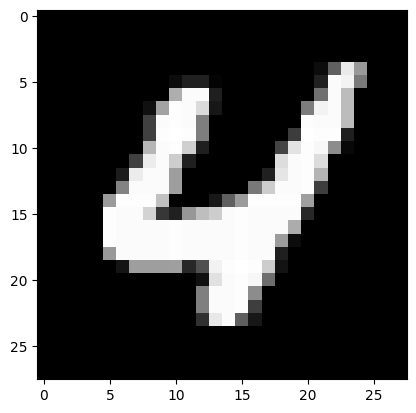

In [3]:
# Show a random image

img_array, label = train_dataset[6128]
img_array = img_array.squeeze().numpy()

print(f"Label = {label}")
plt.imshow(img_array, cmap="gray")
plt.show()

## Model

In [4]:
class DeepMulticlass(nn.Module):
    def __init__(self, input_size, output_size, dropout=0.2):
        super().__init__()
        self.classifier = nn.Sequential(
            # Layer 1
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            # Layer 2
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            # Layer 3
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            # Output
            nn.Linear(32, output_size)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(x)

## Train

In [38]:
sample_x, sample_y = train_dataset[0]

input_size = torch.numel(sample_x.squeeze())
output_size = 10

model = DeepMulticlass(input_size, output_size)
model

DeepMulticlass(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [39]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

n_epochs = 50
train_loss = []
test_accuracy = []

for epoch in range(n_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(images.view(-1, input_size))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Store final loss after training batch
    epoch_loss = loss.item()
    train_loss.append(loss.item())

    # Compute test dataset accuracy
    correct = 0
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        preds = model(images.view(-1, input_size))
        pred_labels = preds.argmax(1)
        correct += (pred_labels == labels).sum()

    epoch_accuracy = correct.item() / len(test_dataset)
    test_accuracy.append(epoch_accuracy)

    print(f"Epoch = {epoch}, Train Loss = {epoch_loss}, Test Accuracy = {epoch_accuracy}")

Epoch = 0, Train Loss = 1.0513758659362793, Test Accuracy = 0.8367
Epoch = 1, Train Loss = 1.0121983289718628, Test Accuracy = 0.8884
Epoch = 2, Train Loss = 0.6195076704025269, Test Accuracy = 0.9155
Epoch = 3, Train Loss = 0.5660710334777832, Test Accuracy = 0.9217
Epoch = 4, Train Loss = 0.5921851992607117, Test Accuracy = 0.9279
Epoch = 5, Train Loss = 0.4706861972808838, Test Accuracy = 0.9348
Epoch = 6, Train Loss = 0.47862866520881653, Test Accuracy = 0.9411
Epoch = 7, Train Loss = 0.3037016689777374, Test Accuracy = 0.9432
Epoch = 8, Train Loss = 0.4543878734111786, Test Accuracy = 0.9463
Epoch = 9, Train Loss = 0.3853706121444702, Test Accuracy = 0.9491
Epoch = 10, Train Loss = 0.32685285806655884, Test Accuracy = 0.9526
Epoch = 11, Train Loss = 0.09718881547451019, Test Accuracy = 0.9559
Epoch = 12, Train Loss = 0.3522353172302246, Test Accuracy = 0.9572
Epoch = 13, Train Loss = 0.19193698465824127, Test Accuracy = 0.9589
Epoch = 14, Train Loss = 0.4719291031360626, Test Accu

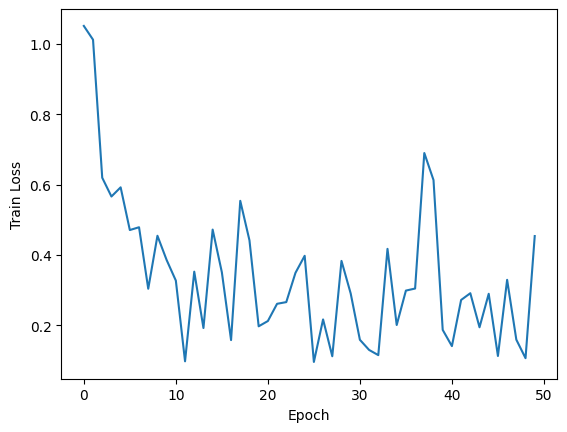

In [41]:
plt.plot(train_loss)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.show()

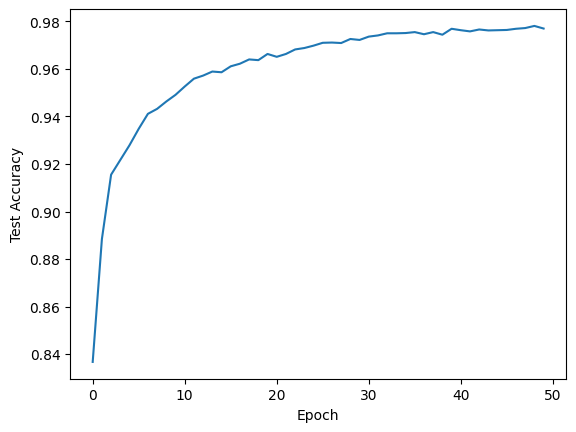

In [42]:
plt.plot(test_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.show()